In [1]:
#Storing the data we already have
#AFTER OPENING DOC
import dbm
import pickle

db = dbm.open('Odds August 2021','c')
pchdr = db["August2021"]
db.close()
august = pickle.loads(pchdr)

In [2]:
import urllib
from selenium import webdriver
import time
from selenium.webdriver.common.keys import Keys
from selenium.common.exceptions import ElementClickInterceptedException
import numpy as np

In [3]:
import json
import re
import time
from datetime import datetime

import requests

def get_response(url: str) -> str:
    #Helper function for scraper below
    return requests.get(url, headers=headers).text

headers = {
    "accept": "*/*",
    "accept-encoding": "gzip, deflate, br",
    "accept-language": "en-US,en;q=0.9,pl;q=0.8",
    "referer": "https://www.oddsportal.com/",
    "user-agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 11_5_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.107 Safari/537.36"
}


history_columns = {
    "1": "4kflpxv498x0x0",  # 1 column
    "2": "4kflpxv464x0xc59n2",  # 2 column
    "X": "4kflpxv464x0xc59n1",  # X column
}

#Bet codes: Pinnacle: 18, 1xBet: 417, WilliamHill: 15, bet365: 16, Unibet: 5, Marathonbet:381

betcodes = ['18']#['18','417','15','5','381']
bookies = ['Pinnacle','Marathonbet']#['Pinnacle', '1xBet','WilliamHill','bet365','Unibet','Marathonbet']
regex_oplinks = re.compile("https://www.oddsportal.com/.*/.*/.*/.*/")
non_oplinks = re.compile(".*redirect.*")
leagues = ["usa/mls","mexico/liga-mx","germany/3-liga","romania/liga-1","ekstraklasa","russia/premier-league","ukraine/premier-league","sweden/allsvenskan","sweden/superettan","belgium/jupiler-league","croatia/1-hnl","czech-republic/1-liga","denmark/superliga","england/premier-league","england/championship","england/league-one","england/league-two","estonia/esiliiga","europe/champions-league","europe/europa-conference-league","finland/veikkausliiga","france/ligue-1","france/ligue-2","germany/bundesliga","germany/2-bundesliga","hungary/otp-bank-liga","reland/premier-division","italy/serie-a","netherlands/eredivisie","japan/j1-league","norway/eliteserien","scotland/premiership","slovakia/fortuna-liga","spain/laliga","switzerland/super-league","switzerland/challenge-league"]
months = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]

def get_oplinks(op_page):
    #Gets links from oddsportal homepage
    
    options = webdriver.ChromeOptions()
    options.add_argument('headless')
    driver = webdriver.Chrome(executable_path = "/Users/pietervantol/Documents/chromedriver",options = options)

    driver.get(op_page)
    links = driver.find_elements_by_xpath('//a[@href]')

    output = list()
    for link in links:
        newlink = link.get_attribute("href")
        if regex_oplinks.match(newlink) and any(league in newlink for league in leagues):
            output.append(newlink)
        
    driver.close()
    return output

def api_result(game_url):
    #Find API request link for result
    
    options = webdriver.ChromeOptions()
    options.add_argument('headless')
    driver = webdriver.Chrome(executable_path = "/Users/pietervantol/Documents/chromedriver",options = options)
    driver.get(game_url)
    time.sleep(0.5)
    test = driver.execute_script("var performance = window.performance || window.mozPerformance || window.msPerformance || window.webkitPerformance || {}; var network = performance.getEntries() || {}; return network;")
    driver.close()
    for item in test:
        if "fb.oddsportal.com/feed/postmatch" in item['name']:
            return item['name']    


        
def convert_optime(string):
    commas = list()
    for m in re.finditer(',',string):
        commas.append((m.start()))
    
    day = int(string[commas[0]+2:commas[0]+4])
    month = string[commas[0]+5:commas[0]+8]
    year = int(string[commas[0]+9:commas[0]+13])
    hour = int(string[commas[1]+2:commas[1]+4])
    minute = int(string[commas[1]+5:commas[1]+8])
    
    iteration = 1
    for monthname in months:
        
        if monthname == month:
            month = iteration
            break
        iteration += 1
    output = [year,month,day,hour,minute]
    
    return output 
        
def api_link(game_url):
    #Find API request link for historical odds
    
    options = webdriver.ChromeOptions()
    options.add_argument('headless')
    driver = webdriver.Chrome(executable_path = "/Users/pietervantol/Documents/chromedriver",options = options)
    driver.get(game_url)
    time.sleep(0.5)
    test = driver.execute_script("var performance = window.performance || window.mozPerformance || window.msPerformance || window.webkitPerformance || {}; var network = performance.getEntries() || {}; return network;")
    date_time = driver.find_element_by_xpath('/html/body/div[1]/div/div[2]/div[6]/div[1]/div/div[1]/div[2]/div[1]/p[1]').text
    driver.close()
    
    date_time = convert_optime(date_time)
    
    date_time = datetime(date_time[0],date_time[1],date_time[2], hour = date_time[3], minute = date_time[4]).timestamp()
    
    output = dict()
    output['time'] = date_time
    for item in test:
        if "fb.oddsportal.com/feed/match" in item['name']:
            output['odds'] = item['name']
            
        elif "fb.oddsportal.com/feed/postmatch" in item['name']:
            output['result'] = item['name']
    return output

def remove_dups(dictz):
    compz_reg = list()
    output = list()
    for comp in dictz:
        if comp[0] not in compz_reg: 
            output.append(comp)
            compz_reg.append(comp[0])
    return output

def sort_list(dictz):
    output = [dictz[0]]
    for comp in dictz[1:len(dictz)]:
        for j in range(0,len(output)):
            
            if comp[0] > output[j][0]:
                if j == len(output) - 1:
                    output.append(comp)
                    break
                else:
                    continue
            else:
                if j == 0:
                    output = [comp] + output[j:len(output)]
                else:
                    output = output[0:j] + [comp] + output[j:len(output)]
                break
            
    return output

def update_histodds_api(url,dicts):
    #Gets historical odds and result from oddsportal url and updates existing dictionary
    
    slash_its = list()
    for m in re.finditer('/',url):
        slash_its.append((m.start()))
    
    
    base_url = url
    urls = api_link(url)
    
    try:
        url = urls['odds']
        
    except:
        print("Game in Progress")
        return dicts
    try:
        time_now_ms = int(round(time.time() * 1000))
        res_url = urls['result']
        #print(res_url)
        res_data_js = f"{res_url}{time_now_ms}.js"
        res_data = json.loads(re.findall(r"\.dat',\s({.*})", get_response(res_data_js))[0])
    except:
        pass
        
    
    


    try:
        kickoff_time = res_data['d']['startTime']
    except:
        kickoff_time = urls['time']
    
    odds_data_js = f"{url}{time_now_ms}.js"
    
    odds_data = json.loads(re.findall(r"\.dat',\s({.*})", get_response(odds_data_js))[0])
    
    output = dict()
    
    for key in odds_data['d']['oddsdata']['back'].keys():
        idkey = key
        break
    
    try:
        #print(odds_data['d']['oddsdata']['back'].keys())
        home_id = odds_data['d']['oddsdata']['back'][idkey]['OutcomeID']['0']
    except:
        home_id = odds_data['d']['oddsdata']['back'][idkey]['OutcomeID'][0]
    try:
        away_id = odds_data['d']['oddsdata']['back'][idkey]['OutcomeID']['2']
    except:
        away_id = odds_data['d']['oddsdata']['back'][idkey]['OutcomeID'][2]
    
    try:
        draw_id = odds_data['d']['oddsdata']['back'][idkey]['OutcomeID']['1']
    
    except:
        draw_id = odds_data['d']['oddsdata']['back'][idkey]['OutcomeID'][1]
    
    
    time_now = time.time()
    
    if time_now > kickoff_time:
        time_to_game = 0
    else:
        time_to_game = kickoff_time - time_now
    
    for dig in range(0,len(betcodes)):
        b_output = dict()
        
        try:
            home = odds_data['d']['history']['back'][home_id][betcodes[dig]]
            
            away = odds_data['d']['history']['back'][away_id][betcodes[dig]]
            draw = odds_data['d']['history']['back'][draw_id][betcodes[dig]]
            finalodds = odds_data['d']['oddsdata']['back']['E-1-2-0-0-0']['odds'][betcodes[dig]]
        
            try:
                home_odds = [[time_to_game, finalodds[0]]]
                away_odds = [[time_to_game, finalodds[2]]]
                draw_odds = [[time_to_game, finalodds[1]]]
                
            except:
                home_odds = [[time_to_game, finalodds['0']]]
                away_odds = [[time_to_game, finalodds['2']]]
                draw_odds = [[time_to_game, finalodds['1']]]
            
            for comp in home:
                home_odds.append([kickoff_time - comp[2],comp[0]])
            
            
            b_output["home"] = home_odds
            for comp in away:
                away_odds.append([kickoff_time - comp[2],comp[0]])
                
            for comp in draw:
                draw_odds.append([kickoff_time - comp[2],comp[0]])
            

                
            b_output["home"] = home_odds  
            b_output["away"] = away_odds
            b_output["draw"] = draw_odds
        
        
            if base_url[slash_its[5]:slash_its[6]] in dicts.keys():
                if bookies[dig] in dicts[base_url[slash_its[5]:slash_its[6]]]:
                    dicts[base_url[slash_its[5]:slash_its[6]]][bookies[dig]]["home"] = dicts[base_url[slash_its[5]:slash_its[6]]][bookies[dig]]["home"] + home_odds
                    #print(dicts[base_url[slash_its[5]:slash_its[6]]][bookies[dig]]["home"])
                    #print("That was all entries combined")
                    dicts[base_url[slash_its[5]:slash_its[6]]][bookies[dig]]["away"] = dicts[base_url[slash_its[5]:slash_its[6]]][bookies[dig]]["away"] + away_odds
                    dicts[base_url[slash_its[5]:slash_its[6]]][bookies[dig]]["draw"] = dicts[base_url[slash_its[5]:slash_its[6]]][bookies[dig]]["draw"] + draw_odds
                    #Sorting by time to game start
                    #if True:
                        #print(remove_dups(dicts[base_url[slash_its[5]:slash_its[6]]][bookies[dig]]['home']))
                        #return remove_dups(dicts[base_url[slash_its[5]:slash_its[6]]][bookies[dig]]['home'])
                    dicts[base_url[slash_its[5]:slash_its[6]]][bookies[dig]]["home"] = sort_list(remove_dups(dicts[base_url[slash_its[5]:slash_its[6]]][bookies[dig]]['home']))
                    #dicts[base_url[slash_its[5]:slash_its[6]]][bookies[dig]] = sort_list(dicts[base_url[slash_its[5]:slash_its[6]]][bookies[dig]]) 
                    dicts[base_url[slash_its[5]:slash_its[6]]][bookies[dig]]["away"] = sort_list(remove_dups(dicts[base_url[slash_its[5]:slash_its[6]]][bookies[dig]]['away']))
                    dicts[base_url[slash_its[5]:slash_its[6]]][bookies[dig]]["draw"] = sort_list(remove_dups(dicts[base_url[slash_its[5]:slash_its[6]]][bookies[dig]]['draw']))
                else:
                    dicts[base_url[slash_its[5]:slash_its[6]]][bookies[dig]] = b_output
                
            else:
                dicts[base_url[slash_its[5]:slash_its[6]]] = dict()
                dicts[base_url[slash_its[5]:slash_its[6]]][bookies[dig]] = b_output
             
        
        except:
            print("No odds provided by betting provider no.")
            print(dig)
            continue
    
    try:
        #print(float(res_data['d']['result'][65]))
        #print(float(res_data['d']['result'][67]))
        if int(res_data['d']['result'][65]) > int(res_data['d']['result'][67]):
            dicts[base_url[slash_its[5]:slash_its[6]]]['result'] = "home"
        elif int(res_data['d']['result'][65]) == int(res_data['d']['result'][67]):
            dicts[base_url[slash_its[5]:slash_its[6]]]['result'] = "draw"
        
        else:
            dicts[base_url[slash_its[5]:slash_its[6]]]['result'] = "away"
    except:
        print("Postponed/No final result yet")
    
    return dicts
            


In [4]:
linksaug21 = get_oplinks("https://www.oddsportal.com/matches/soccer/20210821/")


In [5]:
linksaug21

['https://www.oddsportal.com/soccer/mexico/liga-mx/mazatlan-fc-u-a-n-l-tigres-j9LgFFLi/',
 'https://www.oddsportal.com/soccer/usa/mls/los-angeles-galaxy-san-jose-earthquakes-CzCzwiJQ/',
 'https://www.oddsportal.com/soccer/czech-republic/1-liga-women/dukla-prague-liberec-pjHLNwPC/',
 'https://www.oddsportal.com/soccer/europe/champions-league-women/nsa-sofia-rigas-fs-nofoGpUu/',
 'https://www.oddsportal.com/soccer/japan/j1-league/yokohama-f-marinos-vegalta-sendai-6VdIXrUP/',
 'https://www.oddsportal.com/soccer/japan/j1-league/vissel-kobe-kashima-antlers-bTycQ0Ma/',
 'https://www.oddsportal.com/soccer/czech-republic/1-liga-women/lokomotiva-brno-plzen-bgLPMcvJ/',
 'https://www.oddsportal.com/soccer/europe/champions-league-women/minsk-fk-celtic-tpRObqa5/',
 'https://www.oddsportal.com/soccer/europe/champions-league-women/peamount-kk-nike-APIue1bU/',
 'https://www.oddsportal.com/soccer/europe/champions-league-women/okzhetpes-lokomotiv-moscow-0lbkF4qn/',
 'https://www.oddsportal.com/soccer/ja

In [14]:
august["aug19"] = dict()

In [6]:
for num in range(50,len(linksaug21)):
    print(num)
    print(linksaug21[num])
    august["aug21"] = update_histodds_api(linksaug21[num],august["aug21"])

50
https://www.oddsportal.com/soccer/england/championship/bournemouth-blackpool-t6QRSYJI/
51
https://www.oddsportal.com/soccer/england/championship/coventry-reading-KdPVRhZO/
52
https://www.oddsportal.com/soccer/england/championship/derby-middlesbrough-6ap6jxCP/
53
https://www.oddsportal.com/soccer/england/championship/fulham-hull-city-88WXodKt/
54
https://www.oddsportal.com/soccer/england/championship/luton-birmingham-2VVyoGZn/
55
https://www.oddsportal.com/soccer/england/championship/preston-peterborough-GYZupzkg/
56
https://www.oddsportal.com/soccer/england/championship/sheffield-utd-huddersfield-xlOlrEJ5/
57
https://www.oddsportal.com/soccer/england/championship/stoke-city-nottingham-6NShsYYB/
58
https://www.oddsportal.com/soccer/england/championship/cardiff-millwall-p6HfbuSg/
59
https://www.oddsportal.com/soccer/england/league-one/bolton-oxford-utd-YotuMeX6/
60
https://www.oddsportal.com/soccer/england/league-one/cambridge-utd-burton-CxuqLFnD/
61
https://www.oddsportal.com/soccer/

141
https://www.oddsportal.com/soccer/russia/premier-league/krylya-sovetov-samara-pfc-sochi-I1fhprcP/
142
https://www.oddsportal.com/soccer/spain/laliga/granada-cf-valencia-vLpNkehC/
143
https://www.oddsportal.com/soccer/spain/laliga/espanyol-villarreal-MqzSlF7I/
144
https://www.oddsportal.com/soccer/spain/laliga2/tenerife-gijon-jXiAe9H4/
145
https://www.oddsportal.com/soccer/europe/champions-league-women/bordeaux-kristianstads-xxC8qhx4/
146
https://www.oddsportal.com/soccer/netherlands/eredivisie/psv-cambuur-rR6XNITD/
147
https://www.oddsportal.com/soccer/netherlands/eredivisie/sparta-rotterdam-heracles-f1AyNxqK/
148
https://www.oddsportal.com/soccer/norway/eliteserien/stromsgodset-brann-2cYJ0eTd/
149
https://www.oddsportal.com/soccer/poland/ekstraklasa/leczna-wisla-hQaLvm6I/
150
https://www.oddsportal.com/soccer/germany/2-bundesliga/hansa-rostock-dresden-xUm7DJok/
151
https://www.oddsportal.com/soccer/hungary/otp-bank-liga/honved-paks-WbD3XUbI/
152
https://www.oddsportal.com/soccer/r

In [250]:
#Storing the data we already have
#BEFORE CLOSING DOC
import dbm
import pickle

db = dbm.open('Odds August 2021', 'c')

pchdr = pickle.dumps(august)
db["August2021"] = pchdr
db.close()

In [105]:
#To check for unupdated entries on following day
for key in august["aug13"].keys():
    if "result" not in august["aug13"][key].keys():
         print(key)

In [152]:
august["aug16"]

{'/santos-laguna-guadalajara-chivas-0K6B2xxn': {'Pinnacle': {'home': [[0,
     2.09],
    [314, '2.08'],
    [637, '2.07'],
    [2232, '2.10'],
    [7695, '2.11'],
    [10707, '2.10'],
    [10887, '2.11'],
    [10889.870821237564, 2.12],
    [12227, '2.12'],
    [13210, '2.13'],
    [20497, '2.12'],
    [20556, '2.14'],
    [20615, '2.13'],
    [23039, '2.14'],
    [24622, '2.12'],
    [27847, '2.15'],
    [30266, '2.17'],
    [42220, '2.15'],
    [44186, '2.22'],
    [46422, '2.20'],
    [47023, '2.23'],
    [55033, '2.22'],
    [55064, '2.20'],
    [55116, '2.22'],
    [68411, '2.20'],
    [68940.09720611572, 2.22],
    [71622.0, '2.20'],
    [72223.0, '2.23'],
    [72355, '2.21'],
    [80233.0, '2.22'],
    [80264.0, '2.20'],
    [80316.0, '2.22'],
    [80986, '2.15'],
    [83467, '2.14'],
    [93611.0, '2.20'],
    [97555.0, '2.21'],
    [106186.0, '2.15'],
    [108667.0, '2.14'],
    [121783.0, '2.12'],
    [240976.70620298386, 2.14],
    [306922.0, '2.14'],
    [315430.0, '2.15']

In [11]:
winnings = 0
bets = 0
results = ['home','draw','away']
for key in august["aug21"].keys():
    try:
        odds = august["aug21"][key]['Pinnacle']
    
        for res in ["home","away","draw"]:
            for num in range(1,len(odds[res])):
                #print(float(odds[res][num][1]))
                if 2 < float(odds[res][num][1]) < 10:
                    if (0.85*float(odds[res][num][1]) > float(odds[res][0][1])) & (odds[res][num][0] < 5400):
                        if res == august["aug21"][key]['result']:
                            winnings = winnings + float(odds[res][0][1])-1
                            bets += 1
                            print(key)
                            print(float(odds[res][0][1])-1)
                            break
                        else:
                            winnings = winnings - 1
                            bets += 1
                            print(key)
                            print(-1)
                            break
    except:
        print("No pinnacle odds")
        continue
#print(winnings/bets)
print(winnings)
bets

/brondby-slovacko-WYJydsqO
-1
/atlas-toluca-QXvmkvLb
1.9300000000000002
/mitrovica-agarista-ss-anenii-noi-ra8LaPqa
0.1499999999999999
/ch-odessa-shakhtar-zD72j1Z4
-1
/biik-shymkent-glasgow-city-UggCdNhI
-1
-0.9199999999999999


5

In [15]:
time_success = list()
time_fail = list()
winnings = 0
bets = 0
results = ['home','draw','away']
for masterkey in august.keys():
    print(masterkey)
    for key in august[masterkey].keys():
        try:
            odds = august[masterkey][key]['Pinnacle']
    
            for res in ["home","away","draw"]:
                for num in range(1,len(odds[res])):
                    #print(float(odds[res][num][1]))
                    if 1 < float(odds[res][num][1]) < 10:
                        if (0.87*float(odds[res][num][1]) > float(odds[res][0][1]))& (odds[res][num][0] < 4800):
                            if res == august[masterkey][key]['result']:
                                winnings = winnings + float(odds[res][0][1])-1
                                bets += 1
                                print(key)
                                print(float(odds[res][0][1])-1)
                                time_success.append(odds[res][num][0])
                                break
                            else:
                                winnings = winnings - 1
                                bets += 1
                                print(key)
                                time_fail.append(odds[res][num][0])
                                print(-1)
                                break
        except:
            print("No pinnacle odds")
            continue
print(winnings/bets)
print(winnings)
print(bets)

aug10
No pinnacle odds
aug11
aug12
/elva-nomme-utd-AakikrGl
0.8799999999999999
/rubin-kazan-rakow-czestochowa-dSNkzIuc
1.7400000000000002
aug13
/viborg-randers-fc-MVhnsDLa
-1
/aston-villa-nottingham-6ax9NanG
-1
aug14
/vfl-osnabruck-wehen-4tH1ZJIL
1.42
/waalwijk-az-alkmaar-dfGcBup8
4.13
/afc-eskilstuna-norrby-SOFRId4P
1.2799999999999998
/paide-linnameeskond-maardu-linnameeskond-W8jmjO0r
-1
/toluca-juarez-vLrSbPyB
-1
aug15
/guadalajara-chivas-necaxa-YsrWcqiH
-1
/spartak-trnava-z-moravce-vrable-MPLZU97r
-1
/bayern-munich-1-fc-nurnberg-2ctngFa0
-1
/bayern-munich-1-fc-nurnberg-2ctngFa0
3.0700000000000003
/wolfsburg-rb-leipzig-8fqfigUC
0.56
aug16
/west-ham-arsenal-AH4GEDUe
0.6100000000000001
/wolves-middlesbrough-OjySwLWd
2.08
/crystal-palace-leeds-fq3qMexM
-1
/tottenham-chelsea-Gf5CFgFk
-1
/stoke-city-birmingham-ELgyHcPq
-1
aug20
/maardu-linnameeskond-flora-tallinn-I1ACdQNE
1.8199999999999998
/hammarby-eskilstuna-united-INi7Hy0T
2.91
aug21
/minsk-fk-celtic-tpRObqa5
-1
/brondby-slovacko-WYJy

In [129]:
def winnings_scope(scope):
    winnings = 0
    bets = 0
    results = ['home','draw','away']
    for masterkey in august.keys():
        #print(masterkey)
        for key in august[masterkey].keys():
            try:
                odds = august[masterkey][key]['Pinnacle']
    
                for res in ["home","away","draw"]:
                    for num in range(1,len(odds[res])):
                        #print(float(odds[res][num][1]))
                        if 2 < float(odds[res][num][1]) < 10:
                            if (0.9*float(odds[res][num][1]) > float(odds[res][0][1])) & (odds[res][num][0] < scope):
                                if res == august[masterkey][key]['result']:
                                    winnings = winnings + float(odds[res][0][1])-1
                                    bets += 1
                                    #print(key)
                                    #print(float(odds[res][0][1])-1)
                                    time_success.append(odds[res][num][0])
                                    break
                                else:
                                    winnings = winnings - 1
                                    bets += 1
                                    #print(key)
                                    time_fail.append(odds[res][num][0])
                                    #print(-1)
                                    break
            except:
                pass
                #print("No pinnacle odds")
                continue
                
    if bets == 0:
        return 0
    return bets          



No result found
No result found


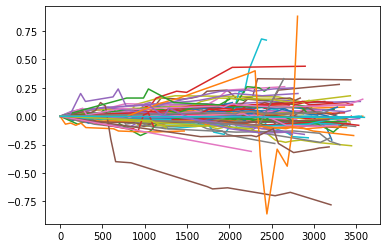

In [76]:
import matplotlib.pyplot as plt
results = ["home","away","draw"]
for key in august["aug15"]:
    x = []
    y = []
    first_ent = True
    try:
        for res in results:
            if august["aug15"][key]["result"] == res:
                for entry in august["aug15"][key]["Pinnacle"][res]:
                    if first_ent == True:
                        base = float(entry[1])
                        first_ent = False
                    if entry[0] < 3600:
                        x.append(float(entry[0]))
                        y.append(float(entry[1]) - base)
                plt.plot(x,y)
    except:
        print("No result found")

In [242]:
def min_within(time1,time2,data):
    minz = [21000,0]
    #print(data)
    for ind in range(1,len(data)):
        #print(time1)
        #print(time2)
        #print(data[ind][0])
        if (data[ind][0] > time1) & (data[ind][0] < time2) & (minz[0] > data[ind][0]):
            minz = data[ind]
    return minz

def mean_gradient(time1,time2,data):
    #print(data)
    maxz = min_within(time2,time2+3600,data)
    #print(maxz)
    minz = min_within(time1,time2,data)
    #print(minz)
    
    return (float(maxz[1])-float(minz[1]))/(time1-time2)

results = ["home","away","draw"]
#segments = [0,1800,3600,5400,7200,9000,10800]
#segments = [0,900,1800,2700,3600,4500,5400,6300,7200,8100,9000,9900,10800]
segments = []
ind = 0
while True:
    if 1800*ind > 11000:
        break
    segments.append(1800*ind)
    ind += 1
print(segments)
x = []
y = []
for masterkey in august.keys():
    if masterkey != "0":
        for key in august[masterkey].keys():
            y_used = False
            try:
                for res in results:
                    entry = []
                    if res == august[masterkey][key]["result"]:
                        y.append(1)
                        y_used = True
                    else:
                        y.append(0)
                        y_used = True
                    for i in range(0,len(segments)-1):
                        entry.append(mean_gradient(segments[i],segments[i+1],august[masterkey][key]["Pinnacle"][res]))
                    entry.append(august[masterkey][key]["Pinnacle"][res][0][1])
                    x.append(entry)     
            except:
                if y_used == True:
                    y = y[0:len(y)-1]
                print("No result found")

[0, 1800, 3600, 5400, 7200, 9000, 10800]
No result found
No result found
No result found
No result found
No result found
No result found
No result found
No result found
No result found
No result found
No result found
No result found
No result found
No result found
No result found
No result found
No result found
No result found
No result found
No result found
No result found
No result found
No result found
No result found
No result found
No result found
No result found
No result found
No result found
No result found
No result found
No result found
No result found
No result found
No result found
No result found
No result found
No result found
No result found
No result found
No result found
No result found
No result found
No result found
No result found


In [243]:
x

[[-5.555555555555561e-06,
  -0.0,
  -0.0007833333333333333,
  0.0007833333333333333,
  -0.0,
  -0.0007833333333333333,
  1.37],
 [0.00019444444444444424,
  -2.2222222222222244e-05,
  5.55555555555593e-06,
  -2.7777777777778172e-05,
  0.004016666666666667,
  -0.004,
  7.52],
 [0.00015000000000000026,
  2.7777777777777677e-05,
  5.555555555555437e-06,
  0.00011666666666666665,
  0.0026333333333333334,
  -0.002627777777777778,
  5.29],
 [-2.2222222222222244e-05,
  -0.0007277777777777778,
  5.555555555555561e-06,
  -5.555555555555561e-06,
  -5.555555555555561e-06,
  -1.1111111111111122e-05,
  1.24],
 [0.0013055555555555555,
  -0.005677777777777778,
  0.00010000000000000083,
  4.44444444444435e-05,
  6.111111111111178e-05,
  0.00029444444444444407,
  11.91],
 [0.0003777777777777776,
  -0.002955555555555556,
  2.7777777777778172e-05,
  2.7777777777777677e-05,
  8.888888888888897e-05,
  8.888888888888847e-05,
  5.82],
 [-2.2222222222222244e-05,
  0.0014833333333333332,
  -0.0,
  -0.0,
  -0.0,

In [244]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(x, y)

In [245]:
wins = 0
for num in range(0,len(x)):
    holder = np.array(x[num])
    if clf.predict(holder.reshape(1,-1)) == y[num]:
        wins += 1

wins

1460

In [246]:
win_abs = 0
for num in range(0,len(x)):
    holder = np.array(x[num])
    #print(clf.predict(holder.reshape(1,-1)))
    if clf.predict(holder.reshape(1,-1)) == 1:
        if y[num] == 1:
            win_abs += x[num][len(x[num])-1] - 1
        else:
            win_abs = win_abs - 1

win_abs

21.739999999999988

In [247]:
wins/len(x)

0.7263681592039801

In [248]:
clf.coef_

array([[-0.01953694,  0.01855582,  0.01639018, -0.02391742, -0.00249073,
        -0.00786518, -0.55732851]])

In [249]:
x[1]

[0.00019444444444444424,
 -2.2222222222222244e-05,
 5.55555555555593e-06,
 -2.7777777777778172e-05,
 0.004016666666666667,
 -0.004,
 7.52]

In [228]:
xtest = []
ytest = []
for masterkey in august.keys():
    if masterkey not in []:
        for key in august[masterkey].keys():
            y_used = False
            try:
                for res in results:
                    entry = []
                    if res == august[masterkey][key]["result"]:
                        ytest.append(1)
                        y_used = True
                    else:
                        ytest.append(0)
                        y_used = True
                    for i in range(0,len(segments)-1):
                        entry.append(mean_gradient(segments[i],segments[i+1],august[masterkey][key]["Pinnacle"][res]))
                    entry.append(august[masterkey][key]["Pinnacle"][res][0][1])
                    xtest.append(entry)
        
            except:
                if y_used == True:
                    ytest = ytest[0:len(ytest)-1]
                print("No result found")

No result found
No result found
No result found
No result found
No result found
No result found
No result found
No result found
No result found
No result found
No result found
No result found
No result found
No result found
No result found
No result found
No result found
No result found
No result found
No result found
No result found
No result found
No result found
No result found
No result found
No result found
No result found
No result found
No result found
No result found
No result found
No result found
No result found
No result found
No result found
No result found
No result found
No result found
No result found
No result found
No result found
No result found
No result found
No result found
No result found


In [229]:
bets = 0
winnings_log = 0
for num in range(0,len(xtest)):
    xtest = np.array(xtest[num])
    probz = clf.predict_proba(xtest[num])
    #print(probz)
    #print(xtest[num][6])
    #print(probz[0][1]*xtest[num][6])
    if (probz[0][1]*xtest[num][6] > 1.08):
        bets += 1
        #print("bet")
        #print(ytest[num])
        if ytest[num] == 1:
            #print("win")
            print(xtest[num][6] - 1)
            winnings_log += xtest[num][6] - 1
        else:
            #print("lose")
            print(-1)
            winnings_log = winnings_log - 1

print(bets)
print(winnings_log/bets)
winnings_log

ValueError: Expected 2D array, got scalar array instead:
array=-5.555555555555561e-06.
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [219]:
bets = 0
winnings_log = 0
for num in range(0,len(x)):
    x = np.array(x)
    probz = clf.predict_proba(x[num].reshape(1,-1))
    #print(probz)
    #print(xtest[num][6])
    #print(probz[0][1]*xtest[num][6])
    if (probz[0][1]*x[num][6] > 1.08):
        bets += 1
        #print("bet")
        #print(ytest[num])
        if y[num] == 1:
            #print("win")
            print(x[num][6] - 1)
            winnings_log += x[num][6] - 1
        else:
            #print("lose")
            print(-1)
            winnings_log = winnings_log - 1

print(bets)
print(winnings_log/bets)
winnings_log

-1
2.0
-1
-1
-1
-1
2.16
2.2
-1
-1
-1
-1
1.9300000000000002
-1
2.14
-1
1.7599999999999998
2.05
-1
-1
-1
2.21
-1
2.21
-1
1.98
1.9100000000000001
-1
-1
-1
-1
2.19
-1
2.27
-1
-1
-1
-1
-1
-1
-1
-1
-1
2.25
-1
-1
2.26
1.9900000000000002
-1
-1
2.09
2.14
-1
2.1
1.9500000000000002
-1
-1
1.83
-1
-1
1.8599999999999999
-1
2.11
-1
-1
-1
-1
-1
-1
-1
-1
1.98
2.24
-1
2.18
-1
-1
-1
2.2
1.8900000000000001
-1
-1
1.7599999999999998
-1
-1
-1
-1
-1
2.13
-1
-1
2.0
2.04
-1
-1
2.07
-1
-1
-1
-1
2.26
2.23
-1
2.09
2.25
2.01
1.87
-1
-1
-1
-1
-1
2.12
-1
-1
-1
-1
2.26
-1
-1
-1
-1
1.7599999999999998
1.9
-1
2.04
-1
-1
-1
-1
-1
1.7200000000000002
1.9100000000000001
-1
1.96
-1
-1
-1
1.98
-1
-1
-1
1.9500000000000002
2.02
-1
1.85
2.14
-1
1.73
-1
-1
1.9300000000000002
-1
-1
-1
1.7999999999999998
1.85
2.0
-1
-1
2.13
-1
-1
-1
-1
2.08
1.88
-1
1.87
-1
1.96
1.8199999999999998
1.9300000000000002
-1
1.9700000000000002
-1
-1
-1
-1
-1
-1
2.18
-1
-1
2.2
1.8399999999999999
-1
-1
2.2
-1
2.23
-1
2.22
-1
-1
1.92
-1
-1
2.08
-1
-1
-1
2.15


17.869999999999997

In [232]:
xtest

array([-5.55555556e-06, -0.00000000e+00, -7.83333333e-04,  7.83333333e-04,
       -0.00000000e+00, -7.83333333e-04,  1.37000000e+00])

In [231]:
xtest[1]

-0.0